In [5]:
import sys
import math
import numpy as np
import seaborn as sn
from copy import copy, deepcopy
from matplotlib import pyplot as plt


class env():
    """
    Jack's Car Rental example in leacture 3.
    States: Two locations, maximum ofn20 car at each.
    Actions: Move up to 5 cars between location overnight.
    Reward: $10 for each car rented (must be avaliable).
    Transitions: Cars returned and requested randomly.
        Poisson distribution, n returns/requests with prob Poisson(lambda)
        1st location: average requests = 3, average returns = 3.
        2nd loaction: average requests = 4, average returns = 2.
    """
    def __init__(self):
        self.p = np.zeros((21, 21)) 
        self.v = np.zeros((21, 21))
        self.a = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
        self.avg_lambda = {"loc1": {"req": 3, "ret": 3}, "loc2": {"req": 4, "ret": 2}}
        self.matrixes = {"loc1": None, "loc2": None}
    
    def get_action(self, s1, s2, action):
        sign = np.sign(action)
        if sign >= 0:
            action = np.min([20-s1, s2, action])
        else:
            action = np.min([s1, 20-s2, np.abs(action)]) * -1
        return int(action)


    def calculate_transition_matrix_item(self, loc, s_start, s_end):
        """ Calculate P(s=s_start, s=s_end) """
        p_start_end = 0
        reward_start_end = 0
        for n_req in range(max(0, s_start - s_end), s_start + 1):
             n_ret = s_end - (s_start - n_req)
             p_ret = self.avg_lambda[loc]["ret"] ** n_ret * np.exp(-self.avg_lambda[loc]["ret"]) / math.factorial(n_ret)
             p_req = self.avg_lambda[loc]["req"] ** n_req * np.exp(-self.avg_lambda[loc]["req"]) / math.factorial(n_req)
             #print(s_start, "+", n_ret, "-", n_ret+s_start-s_end, "=", s_end, "prob=", p_ret*p_req)
             p_start_end += p_ret * p_req
             reward_start_end += 10 * n_req * p_ret * p_req
        return p_start_end, reward_start_end


    def calculate_transition_matrix(self, loc):
        # P(ss')
        p_transition_matrix = np.empty((21, 21)) 
        # P(ss') * R(s'|s)
        reward_transition_matrix = np.empty((21, 21)) 

        for s_start in range(21):
            for s_end in range(21):
                p_transition_matrix[s_start, s_end] = self.calculate_transition_matrix_item(loc, s_start, s_end)[0]
                reward_transition_matrix[s_start, s_end] = self.calculate_transition_matrix_item(loc, s_start, s_end)[1]

        # P(s'|s) = P(ss') / P(s)
        p_start = np.sum(p_transition_matrix, axis=1)
        p_transition_matrix = p_transition_matrix / p_start.reshape(-1, 1)
        # R(s'|s) = R(ss') / p(s)
        reward_transition_matrix = reward_transition_matrix / p_start.reshape(-1, 1)
        
        return p_transition_matrix, reward_transition_matrix


    def get_one_step_value(self, s1_start, s2_start, p_transition_matrix_loc1, p_transition_matrix_loc2, v):
        # sum(Pss' * v(s') for all s' in S)
        one_step_value = np.sum(np.outer(p_transition_matrix_loc1[s1_start], p_transition_matrix_loc2[s2_start]) * v.T)
        return one_step_value
        
        
    def iteration(self, n_iter):
        p_transition_matrix_loc1, reward_transition_matrix_loc1 = self.calculate_transition_matrix("loc1")
        p_transition_matrix_loc2, reward_transition_matrix_loc2 = self.calculate_transition_matrix("loc2")

        
        for _ in range(n_iter):
            # # Policy evaluation
            # tmp_v = copy(self.v)
            # for i in range(21):
            #     for j in range(21):
            #         action = self.get_action(i, j, self.p[i, j])
            #         s1_start, s2_start = i + action, j - action
            #         reward = np.sum(reward_transition_matrix_loc1[s1_start]) + np.sum(reward_transition_matrix_loc2[s2_start])
            #         one_step_value = self.get_one_step_value(s1_start, s2_start, p_transition_matrix_loc1, p_transition_matrix_loc2, tmp_v)
            #         self.v[i, j] = reward + one_step_value

            # Policy Improvement
            v = copy(self.v)
            q =  np.empty((21, 21, 11))
            for i in range(21):
                for j in range(21):
                    # Act by policy
                    action_true = [0] * 11
                    for k in range(11):
                        action = self.a[k] 
                        action_true[k] = self.get_action(i, j, action)
                        s1_start, s2_start = i + action_true[k], j - action_true[k] 
                        reward = np.sum(reward_transition_matrix_loc1[s1_start]) + np.sum(reward_transition_matrix_loc2[s2_start])
                        one_step_value = self.get_one_step_value(s1_start, s2_start, p_transition_matrix_loc1, p_transition_matrix_loc2, v)
                        q[i, j, k] = reward + one_step_value
                    # Improve the policy by acting greedily.
                    self.p[i, j] = action_true[np.argmax(q[i, j])]
                    # print("greedy: ", q[i, j], np.argmax(q[i, j]), action_true[np.argmax(q[i, j])])
                    # Improve the value from any state over one greedy step.
                    self.v[i, j] = np.max(q[i, j])

        return self.p, self.v


def main():
    e = env()
    p, v = e.iteration(1)
    p = p*-1
    print(p)
    print(v)


# if __name__ == "__main__":
#     main()


In [6]:
e = env()
p, v = e.iteration(100)

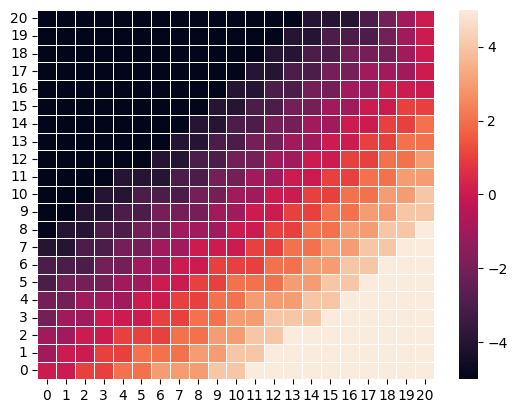

In [7]:
sn.heatmap(p, linewidth=0.5, annot=False).invert_yaxis()